# Inductive node classification and representation learning using GraphSAGE


In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 32.5 MB/s 
     |████████████████████████████████| 482 kB 57.7 MB/s 
     |████████████████████████████████| 462 kB 71.6 MB/s 
     |████████████████████████████████| 41 kB 795 kB/s 


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

import stellargraph as sg
from stellargraph import StellarGraph, StellarDiGraph
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator, DirectedGraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, MeanAggregator, DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.utils.multiclass import unique_labels
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive')

import torch
torch.cuda.is_available()

%matplotlib inline

## Paths

In [48]:
#Specific paths
PATH_DATES = 'hep-th-slacdates_unzipped.txt'
PATH_CITATION = 'hep-th-citations_unzipped_filtered.txt'
PATH_LABEL = 'papers_label.csv'
PATH_ATTRIBUTES = 'all_features_with_further_preprocessing.csv'

PATH_MODEL_GS_D_B = 'graphsage_directed_extra_feat.hdf5'


## Loading the dataset

https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

In [4]:
def read_dates(path):
    df = pd.read_csv(path, sep=' ', header=None, names=['id_paper', 'slac_date'])
    df['slac_date'] = pd.to_datetime(df['slac_date'])
    display(df.head(5))
    return (df)

In [5]:
def read_citation(path, df):
    df = pd.read_csv(path, sep=' ', header=None, names=['source', 'target'])
    display(df.head(5))
    return(df)

In [6]:
def get_labels(path, df2, label, date):
  df1 = pd.read_csv(path, index_col=0)
  df1.index.name='id_paper'
  df2 = df2.set_index("id_paper")
  df1 = pd.merge(df1, df2, left_index=True, right_index=True)
  label_full = df1[label]
  label_train = df1[df1.slac_date < date][label]
  label_test = df1[df1.slac_date >= date][label]
  print('Full nodes: %s   Train nodes: %s   Test nodes: %s'%(len(label_full), len(label_train), len(label_test)))
  return (label_full, label_train, label_test)
  

In [7]:
def get_features(path, df2, date):
  # Papers ids 
  df1 = pd.read_csv(path, index_col=0)
  df1.index.name='id_paper'
  
  # Date df
  df2 = df2.set_index("id_paper")
  
  # Combine datasets
  df1 = pd.merge(df1, df2, left_index=True, right_index=True)

  # Date features
  df1['slac_date'] = pd.to_datetime(df1['slac_date'])
  df1['year']= df1[date].dt.year
  df1['month']= df1[date].dt.month
  df1['week']= df1[date].dt.isocalendar().week
  
  df1['month_sin'] = np.sin((df1.month-1)*(2.*np.pi/12))
  df1['month_cos'] = np.cos((df1.month-1)*(2.*np.pi/12))
  
  df1['week_sin'] = np.sin((df1[date].dt.isocalendar().week-1)*(2.*np.pi/53))
  df1['week_cos'] = np.cos((df1[date].dt.isocalendar().week-1)*(2.*np.pi/53))
  
  ls = ['year', 'month_sin', 'month_cos', 'week_sin', 'week_cos']
  df_date = df1[ls]
  display(df_date.head(5))
  return(df_date)


In [8]:
df_dates = read_dates(PATH_DATES)

,id_paper,slac_date
0,1001,2000-01-04
1,1002,2000-01-04
2,1003,2000-01-04
3,1004,2000-01-04
4,1005,2000-01-04


In [9]:
df_citation = read_citation(PATH_CITATION, df_dates)

,source,target
0,1001,9304045
1,1001,9308122
2,1001,9309097
3,1001,9311042
4,1001,9401139


In [10]:
full_nodes, train_nodes, test_nodes = get_labels(PATH_LABEL, df_dates, 'label', '2002-01-01')

Full nodes: 27750   Train nodes: 23567   Test nodes: 4183


In [11]:
df_attributes = get_features(PATH_LABEL, df_dates, 'slac_date')

,year,month_sin,month_cos,week_sin,week_cos
id_paper,,,,,
1001,2000,0.0,1.0,0.0,1.0
1002,2000,0.0,1.0,0.0,1.0
1003,2000,0.0,1.0,0.0,1.0
1004,2000,0.0,1.0,0.0,1.0
1005,2000,0.0,1.0,0.0,1.0


In [12]:
df_attributes.to_csv('dates_sin_cos.csv')

In [49]:
extra_features = [
    # 'Unnamed: 0', 
    'indegrees_of_cited_papers_sum',
    'indegrees_of_cited_papers_avg', 
    'recency_of_cited_papers_avg',
    'max_time_difference_bw_cited_papers', 
    # 'outdegree',
    # 'outdegrees_of_cited_papers_sum', 
    # 'outdegrees_of_cited_papers_avg',
    # 'submitter', 
    # 'submission_date', 
    # 'title', 
    # 'authors', 
    # 'comments',
    # 'report_no', 
    # 'journal_ref', 
    # 'abstract', 
    # 'submitter_email',
    # 'submitter_name', 
    # 'submitter_details', 
    'is_revised', 
    'times_revised',
    # 'first_submission_datetime', 
    # 'first_submission_date', 
    'num_of_pages',
    # 'format', 
    'journal_counts', 
    # 'first_365_days', 
    # 'label', 
    # 'label_name',
    'submitter_active', 
    'submitter_counts', 
    'journal_popularity',
    'format_latex', 
    'format_revtex', 
    'format_harvmac', 
    'format_plaintex',
    # 'date_added_graph', 
    # 'datedelta', 
    # 'citations_till_date',
]

df_extra_features = pd.read_csv(
    PATH_ATTRIBUTES, 
    index_col=1
)[extra_features].fillna(0)

df_attributes = pd.merge(
    df_attributes, 
    df_extra_features, 
    how='inner',
    left_index=True, 
    right_index=True
).rename_axis('id_paper')

df_attributes.head()

,year,month_sin,month_cos,week_sin,week_cos,indegrees_of_cited_papers_sum_x,indegrees_of_cited_papers_avg_x,recency_of_cited_papers_avg_x,max_time_difference_bw_cited_papers_x,is_revised_x,...,times_revised_y,num_of_pages_y,journal_counts_y,submitter_active,submitter_counts,journal_popularity,format_latex,format_revtex,format_harvmac,format_plaintex
id_paper,,,,,,,,,,,,,,,,,,,,,
1001,2000,0.0,1.0,0.0,1.0,9173,110.518072,1182.903614,2394.0,1,...,1,82.0,0.0,1,5,0,1,0,0,0
1002,2000,0.0,1.0,0.0,1.0,676,18.777778,627.500000,2899.0,0,...,0,11.0,105.0,1,36,1,1,0,0,0
1003,2000,0.0,1.0,0.0,1.0,0,0.000000,11.000000,0.0,0,...,0,4.0,0.0,0,1,0,0,1,0,0
1004,2000,0.0,1.0,0.0,1.0,0,0.000000,442.000000,0.0,0,...,0,7.0,192.0,0,2,1,1,1,0,0
1005,2000,0.0,1.0,0.0,1.0,226,10.761905,602.047619,2201.0,0,...,0,18.0,0.0,0,1,0,1,0,0,0


## Graph construction

In [50]:
graph_citation_full = StellarDiGraph({"paper": df_attributes}, {"cites": df_citation})
print(graph_citation_full.info())


StellarDiGraph: Directed multigraph
 Nodes: 27750, Edges: 351763

 Node types:
  paper: [27750]
    Features: float32 vector, length 28
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [351763]
        Weights: all 1 (default)
        Features: none


In [51]:
graph_citation_train = graph_citation_full.subgraph(train_nodes.index)
print(graph_citation_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 23567, Edges: 271167

 Node types:
  paper: [23567]
    Features: float32 vector, length 28
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [271167]
        Weights: all 1 (default)
        Features: none


### Splitting the data

In [52]:
train_labels, test_labels = model_selection.train_test_split(
    train_nodes,
    train_size=0.7, #0.05
    test_size=None,
    stratify=train_nodes,
    random_state=42,
)

val_labels, test_labels = model_selection.train_test_split(
    test_labels, 
    train_size=0.67, #0.2
    test_size=None, 
    stratify=test_labels, 
    random_state=42,
)

Note using stratified sampling gives the following counts:

In [53]:
from collections import Counter

Counter(train_labels)

Counter({0: 5044, 1: 9509, 2: 1103, 3: 840})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

In [54]:
#get class_weights
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_labels),
    y = train_labels                                                    
)
class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 0.8176050753370341,
 1: 0.43369439478388894,
 2: 3.7388939256572984,
 3: 4.90952380952381}

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [55]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_labels)
val_targets = target_encoding.transform(val_labels)
test_targets = target_encoding.transform(test_labels)

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model we need a generator. The generators are specialized to the model and the learning task so we choose the `GraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-layer model with 10 nodes sampled in the first layer, and 10 in the second.

In [56]:
batch_size = 50
in_samples = [5, 2]
out_samples = [5, 2]


A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [57]:
generator = DirectedGraphSAGENodeGenerator(graph_citation_train, batch_size, in_samples, out_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [58]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)
val_gen = generator.flow(val_labels.index, val_targets, shuffle=True)
test_gen = generator.flow(test_labels.index, test_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [59]:
graphsage_model = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.1 #, activations=["relu"] or  activation=keras.layers.LeakyReLU(alpha=0.01)
)

Now we create a model to predict the 3 categories using Keras softmax layers. Note that we need to use the `G.get_target_size` method to find the number of categories in the data.

In [60]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)


In [61]:
prediction.shape

TensorShape([None, 4])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [62]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-04),
    loss = losses.categorical_crossentropy, #weighted_categorical_crossentropy(weights)
    metrics = [
        metrics.AUC(),
        metrics.CategoricalAccuracy(),
    ] #= ['accuracy'],
)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 28)]      0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 28)]      0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10, 28)]     0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 10, 28)]     0           []                               
                                                                                            

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [63]:
# create callback
callback = ModelCheckpoint(
    filepath=PATH_MODEL_GS_D_B,
    monitor='val_categorical_accuracy',
    verbose=1, 
    save_best_only=True,
    mode='max'
)

#fit the model
history = model.fit(
    train_gen, 
    epochs=100, 
    validation_data=val_gen, 
    class_weight=class_weights,
    verbose=1, 
    shuffle=True,
    callbacks=[callback]
)


Epoch 1/100
329/330 [============================>.] - ETA: 0s - loss: 1.3767 - auc_1: 0.6091 - categorical_accuracy: 0.3389
Epoch 1: val_categorical_accuracy improved from -inf to 0.31243, saving model to graphsage_directed_base.hdf5
330/330 [==============================] - 16s 44ms/step - loss: 1.3757 - auc_1: 0.6094 - categorical_accuracy: 0.3390 - val_loss: 1.3354 - val_auc_1: 0.6452 - val_categorical_accuracy: 0.3124
Epoch 2/100
329/330 [============================>.] - ETA: 0s - loss: 1.3043 - auc_1: 0.7098 - categorical_accuracy: 0.4574
Epoch 2: val_categorical_accuracy improved from 0.31243 to 0.50982, saving model to graphsage_directed_base.hdf5
330/330 [==============================] - 14s 41ms/step - loss: 1.3044 - auc_1: 0.7098 - categorical_accuracy: 0.4571 - val_loss: 1.2759 - val_auc_1: 0.7284 - val_categorical_accuracy: 0.5098
Epoch 3/100
328/330 [============================>.] - ETA: 0s - loss: 1.2260 - auc_1: 0.7446 - categorical_accuracy: 0.4905
Epoch 3: val_cat

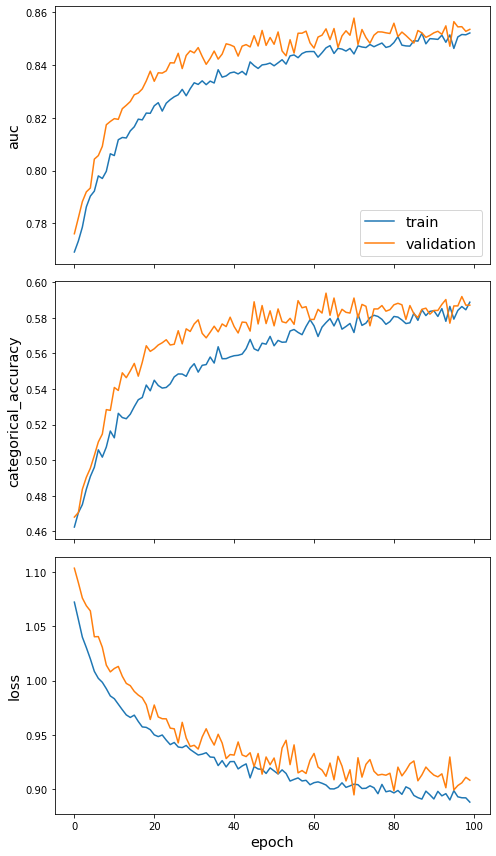

In [38]:
sg.utils.plot_history(history)

### Evaluate the Model

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Now we have trained the model we can evaluate on the test set.

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       714
           1       0.81      0.51      0.63      1345
           2       0.11      0.25      0.16       156
           3       0.24      0.82      0.37       119

    accuracy                           0.59      2334
   macro avg       0.48      0.59      0.48      2334
weighted avg       0.71      0.59      0.62      2334

47/47 [==============================] - 2s 32ms/step - loss: 0.8990 - auc: 0.8563 - categorical_accuracy: 0.5955

Test Set Metrics:
	loss: 0.8990
	auc: 0.8563
	categorical_accuracy: 0.5955


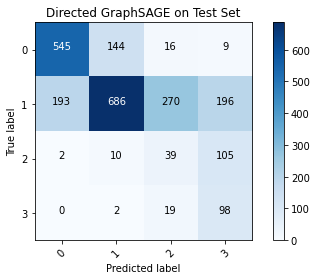

In [40]:
# Make prediction
predictions = model.predict(test_gen)
predictions = target_encoding.inverse_transform(predictions)
results = pd.Series(predictions, index=test_labels.index)

test_gen = generator.flow(test_labels.index, test_targets)

# Evaluation Metrics
cm = confusion_matrix(test_labels, results) #results intead of predictions
plot_confusion_matrix(cm, classes = unique_labels(train_labels), title = "Directed GraphSAGE on Test Set")
print(classification_report(test_labels, results))

# Performance
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

### Making predictions with the model in papers pubblished in 2002 and *2003*

In [41]:
#Load and evaluate the best model version
model = load_model(PATH_MODEL_GS_D_B, custom_objects={'MeanAggregator': MeanAggregator})

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1537
           1       0.98      0.41      0.58      2209
           2       0.08      0.34      0.13       233
           3       0.24      0.76      0.36       204

    accuracy                           0.63      4183
   macro avg       0.56      0.62      0.51      4183
weighted avg       0.87      0.63      0.68      4183

84/84 [==============================] - 3s 31ms/step - loss: 0.8836 - auc: 0.8611 - categorical_accuracy: 0.6333

Prediction Set Metrics:
	loss: 0.8836
	auc: 0.8611
	categorical_accuracy: 0.6333


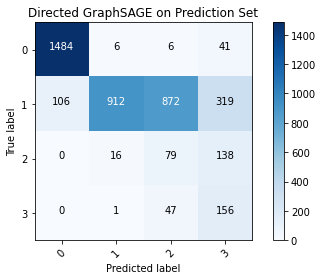

In [42]:
# Introduce prediction nodes
generator = DirectedGraphSAGENodeGenerator(graph_citation_full, batch_size, in_samples, out_samples)
prediction_targets = target_encoding.transform(test_nodes)
prediction_gen = generator.flow(test_nodes.index, prediction_targets)

# Make prediction
predictions = model.predict(prediction_gen)
predictions = target_encoding.inverse_transform(predictions)

# Create prediction dataset
results = pd.Series(predictions, index=test_nodes.index)
df_results = pd.DataFrame({"Predicted": results, "True": test_nodes})

# Evaluation Metrics
cm = confusion_matrix(test_nodes, results) #results intead of predictions
plot_confusion_matrix(cm, classes = unique_labels(train_labels), title = "Directed GraphSAGE on Prediction Set")
print(classification_report(test_nodes, results))

# Performance
prediction_metrics = model.evaluate(prediction_gen)
print("\nPrediction Set Metrics:")
for name, val in zip(model.metrics_names, prediction_metrics):
    print("\t{}: {:0.4f}".format(name, val))